In [19]:
import numpy as np
import numba
import matplotlib.pyplot as plt
import sympy as sym
plt.style.use('presentation')
%matplotlib notebook

def d2np(d):
    
    names = []
    numbers = ()
    dtypes = []
    for item in d:
        names += item   
        if type(d[item]) == float:
            numbers += (d[item],)
            dtypes += [(item,float)]
        if type(d[item]) == int:
            numbers += (d[item],)
            dtypes += [(item,int)]
        if type(d[item]) == np.ndarray:
            numbers += (d[item],)
            dtypes += [(item,np.float64,d[item].shape)]
    return np.array([numbers],dtype=dtypes)

In [20]:
psi_ds,psi_qs,psi_dr,psi_qr = sym.symbols('psi_ds,psi_qs,psi_dr,psi_qr')  
i_ds,i_qs,i_dr,i_qr = sym.symbols('i_ds,i_qs,i_dr,i_qr')  
di_ds,di_qs,di_dr,di_qr = sym.symbols('di_ds,di_qs,di_dr,di_qr')  
L_s,L_r,L_m = sym.symbols('L_s,L_r,L_m')  
R_s,R_r = sym.symbols('R_s,R_r') 
omega_s,omega_r,sigma = sym.symbols('omega_s,omega_r,sigma') 
v_ds,v_qs,v_dr,v_qr = sym.symbols('v_ds,v_qs,v_dr,v_qr')  


eq_ds = (L_s+L_m)*i_ds + L_m*i_dr - psi_ds
eq_qs = (L_s+L_m)*i_qs + L_m*i_qr - psi_qs
eq_dr = (L_r+L_m)*i_dr + L_m*i_ds - psi_dr
eq_qr = (L_r+L_m)*i_qr + L_m*i_qs - psi_qr
dpsi_ds = v_ds - R_s*i_ds + omega_s*psi_qs
dpsi_qs = v_qs - R_s*i_qs - omega_s*psi_ds
dpsi_dr = v_dr - R_r*i_dr + sigma*omega_s*psi_qr
dpsi_qr = v_qr - R_r*i_qr - sigma*omega_s*psi_dr

    
s = sym.solve([  eq_ds,  eq_qs,  eq_dr,  eq_qr,
               dpsi_ds,dpsi_qs,dpsi_dr,dpsi_qr],
              [   i_ds,   i_qs,   i_dr,   i_qr,
                psi_ds, psi_qs,   i_dr, psi_qr])
s = sym.solve([dpsi_ds,dpsi_qs,dpsi_dr,dpsi_qr],
              [   i_ds,   i_qs,   i_dr,   i_qr,
                psi_ds, psi_qs,   i_dr, psi_qr])
for item in s:
    print(item, '=', s[item])

i_qr = (-omega_s*psi_dr*sigma + v_qr)/R_r
i_ds = (omega_s*psi_qs + v_ds)/R_s
i_dr = (omega_s*psi_qr*sigma + v_dr)/R_r
i_qs = (-omega_s*psi_ds + v_qs)/R_s


In [21]:
(L_s+L_m)*i_ds_ref + L_m*i_dr = - psi_ds
(L_s+L_m)*i_qs_ref + L_m*i_qr = - psi_qs


SyntaxError: can't assign to operator (<ipython-input-21-7c2f201dad39>, line 1)

In [95]:
# [1] T. Demiray, F. Milano, and G. Andersson, 
# “Dynamic phasor modeling of the doubly-fed induction generator under unbalanced conditions,” 2007 IEEE Lausanne POWERTECH, Proc., no. 2, pp. 1049–1054, 2007.

@numba.jit(nopython=True, cache=True)
def dfim(struct,i):

    x_idx = struct[i]['dfim_idx']
        
    L_m = struct[i]['L_m']
    L_r = struct[i]['L_r']
    L_s = struct[i]['L_s']
    R_r = struct[i]['R_r']
    R_s = struct[i]['R_s']
    
    Dt  = struct[i]['Dt']
    
    psi_ds = struct[i]['psi_ds'] 
    psi_qs = struct[i]['psi_qs']
    psi_dr = struct[i]['psi_dr'] 
    psi_qr = struct[i]['psi_qr'] 

    i_ds = struct[i]['i_ds'] 
    struct[i]['i_qs'] = i_qs
    struct[i]['i_dr'] = i_dr
    struct[i]['i_qr'] = i_qr
    
    v_ds = struct[i]['v_ds']
    v_qs = struct[i]['v_qs']
    v_dr = struct[i]['v_dr'] 
    v_qr = struct[i]['v_qr']
    
    omega_r = struct[i]['omega_r']
    omega_s = struct[i]['omega_s']
    
    sigma = (omega_s - omega_r)/omega_s
    
    if np.abs(sigma)<0.01:
        
        psi_qr = 0.0
        psi_dr = 0.0
        
        i_qr = ( L_m*psi_qr - L_m*psi_qs + L_s*psi_qr)/(L_m*L_r + L_m*L_s + L_r*L_s)
        i_qs = (-L_m*psi_qr + L_m*psi_qs + L_r*psi_qs)/(L_m*L_r + L_m*L_s + L_r*L_s)
        i_dr = ( L_m*psi_dr - L_m*psi_ds + L_s*psi_dr)/(L_m*L_r + L_m*L_s + L_r*L_s)
        i_ds = (-L_m*psi_dr + L_m*psi_ds + L_r*psi_ds)/(L_m*L_r + L_m*L_s + L_r*L_s)

        psi_qs = (R_s*i_ds - v_ds)/omega_s
        psi_ds = (v_qs - R_s*i_qs)/omega_s
    
    else:

        i_qr = ( L_m*psi_qr - L_m*psi_qs + L_s*psi_qr)/(L_m*L_r + L_m*L_s + L_r*L_s)
        i_qs = (-L_m*psi_qr + L_m*psi_qs + L_r*psi_qs)/(L_m*L_r + L_m*L_s + L_r*L_s)
        i_dr = ( L_m*psi_dr - L_m*psi_ds + L_s*psi_dr)/(L_m*L_r + L_m*L_s + L_r*L_s)
        i_ds = (-L_m*psi_dr + L_m*psi_ds + L_r*psi_ds)/(L_m*L_r + L_m*L_s + L_r*L_s)

        psi_qs = (R_s*i_ds - v_ds)/omega_s
        psi_ds = (v_qs - R_s*i_qs)/omega_s
        psi_qr = (R_r*i_dr - v_dr)/(sigma*omega_s)
        psi_dr = (v_qr - R_r*i_qr)/(sigma*omega_s)

    tau_e  = psi_qr*i_dr - psi_dr*i_qr

    struct[i]['i_ds'] = i_ds
    struct[i]['i_qs'] = i_qs
    struct[i]['i_dr'] = i_dr
    struct[i]['i_qr'] = i_qr
 
    struct[i]['psi_ds'] = psi_ds
    struct[i]['psi_qs'] = psi_qs
    struct[i]['psi_dr'] = psi_dr
    struct[i]['psi_qr'] = psi_qr
    
    struct[i]['tau_e'] = tau_e
    struct[i]['sigma'] = sigma

    return tau_e


@numba.jit(nopython=True, cache=True)
def wecs_mech_1(struct,i):

    x_idx = struct[i]['mech_idx']
    omega_t = struct[i]['x'][x_idx,0]  # rad/s
    tau_t   = struct[i]['tau_t']
    tau_r   = struct[i]['tau_r']
       
    J_t  = struct[i]['J_t']
    N_tr = struct[i]['N_tr']
    Dt   = struct[i]['Dt']

    domega_t = 1.0/J_t*(tau_t - N_tr*tau_r)

    omega_r = N_tr*omega_t 
    
    struct[i]['f'][x_idx,0] = domega_t

    struct[i]['omega_r'] = omega_r
    struct[i]['omega_t'] = omega_t

    return omega_t


In [96]:
Omega_b = 2.0*np.pi*50.0
S_b = 1.0e6
U_b = 690.0
Z_b = U_b**2/S_b
#nu_w =np.linspace(0.1,15,N)
H = 0.001

# H = 0.5*J*Omega_t_n**2/S_b
S_b = 2.0e6
Omega_t_n = 1.5
J_t = 2*H*S_b/Omega_t_n**2


#Z_b = 1.0
#Omega_b = 1.0
d =dict(R_r = 0.01*Z_b,
        R_s = 0.01*Z_b,
        L_r = 0.08*Z_b/Omega_b,
        L_s = 0.1*Z_b/Omega_b,
        L_m = 3.0*Z_b/Omega_b,
        psi_ds = 0.0,
        psi_qs = 0.0,
        psi_dr = 0.0,
        psi_qr = 0.0,
        i_ds   = 0.0,
        i_qs   = 0.0,
        i_dr   = 0.0,
        i_qr   = 0.0,
        v_ds   = 0.0,
        v_qs   = 0.0,
        v_dr   = 0.0,
        v_qr   = 0.0,
        omega_r   = Omega_b*0.99,
        omega_s   = Omega_b,
        sigma   = 0.0,
        tau_e   = 0.0,        
        x = np.zeros((1,1)),
        f = np.zeros((1,1)),   
        Dt = 0.0,
        J_t = J_t,  
        omega_t = 0.0,  
        tau_t = 0.0,  
        tau_r = 0.0, 
        N_tr = 20.0, 
        dfim_idx = 0,
        mech_idx = 0,
        )

struct = d2np(d)
dfim(struct,0)
wecs_mech_1(struct,0)



0.0

In [97]:
struct = d2np(d)
struct['v_ds'] = 325.0
struct['v_qs'] = 0.0
struct['omega_r'] = Omega_b*0.0
Dt = 1.0e-3
struct[0]['x']= np.zeros((1,1))
Tau_e = []
Omega_r = []
T =[]
N_steps = 10000
X = np.zeros((N_steps,1))

def f_eval(struct):
    #dfim(struct,0)
    wecs_mech_1(struct,0)
    return struct[0]['f']
    
    
for it in range(N_steps):
    t = Dt*it
    dfim(struct,0)
    f1 = np.copy(f_eval(struct))
    x1 = np.copy(struct[0]['x'])
    struct[0]['x'] = np.copy(x1 + Dt*f1)
    dfim(struct,0)
    struct[0]['x'] = np.copy(x1 + 0.5*Dt*(f1 + f_eval(struct)))
    struct[0]['tau_r'] =  -struct[0]['tau_e']
    Tau_e   += [float(struct['tau_e'])]
    Omega_r += [float(struct['omega_r'])]    
    T +=[t]    
    

<IPython.core.display.Javascript object>


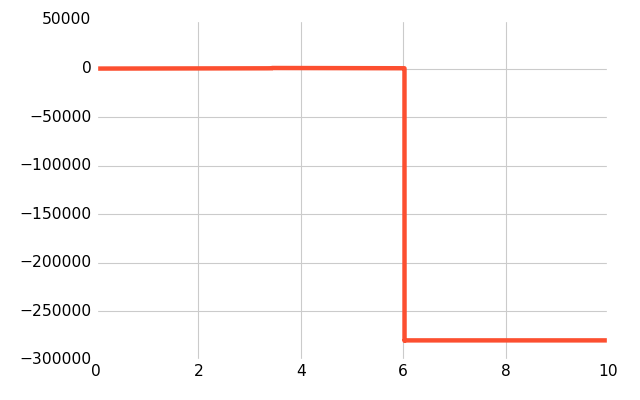

In [98]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8, 5), sharex = True)
axes.plot(T,Omega_r)
fig.savefig('dfim_tau_e.svg', bbox_inches='tight')

<IPython.core.display.Javascript object>


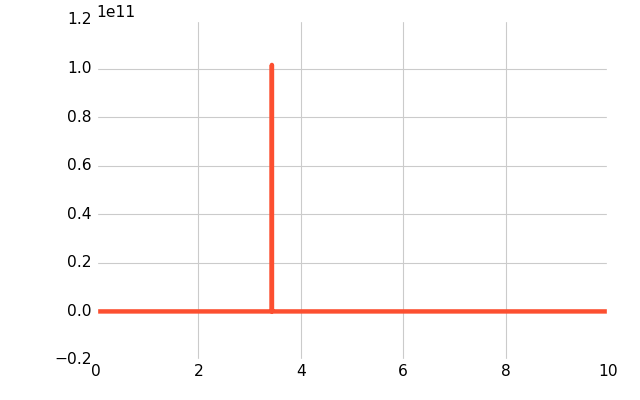

In [94]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8, 5), sharex = True)
axes.plot(T,Tau_e)
fig.savefig('dfim_tau_e.svg', bbox_inches='tight')


<IPython.core.display.Javascript object>


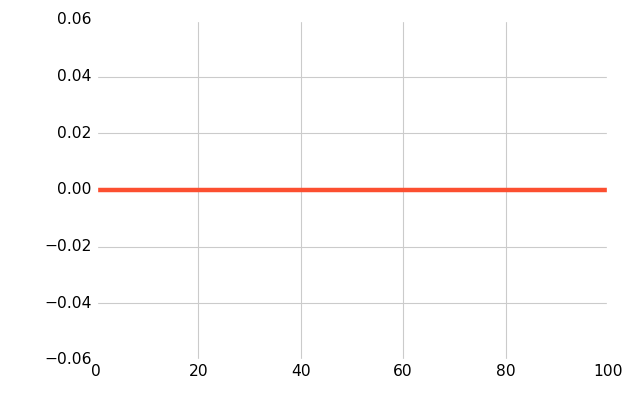

In [61]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8, 5), sharex = True)
axes.plot(T,X[:,0])

In [296]:
X[:,4]

array([  0.00000000e+00,   0.00000000e+00,  -5.74800542e-11, ...,
         1.57079633e+01,   1.57079633e+01,   1.57079633e+01])